In [1]:
import pandas as pd
import numpy as np

In [2]:
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding
from sklearn.model_selection import train_test_split

2023-09-07 21:28:00.551098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 21:28:00.589735: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 21:28:00.590492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 21:28:01.195431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
movie_reviews = pd.read_csv('./datasets/IMDB Dataset.csv')
movie_reviews.isnull().values.any()
movie_reviews.shape
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

<Axes: xlabel='sentiment', ylabel='count'>

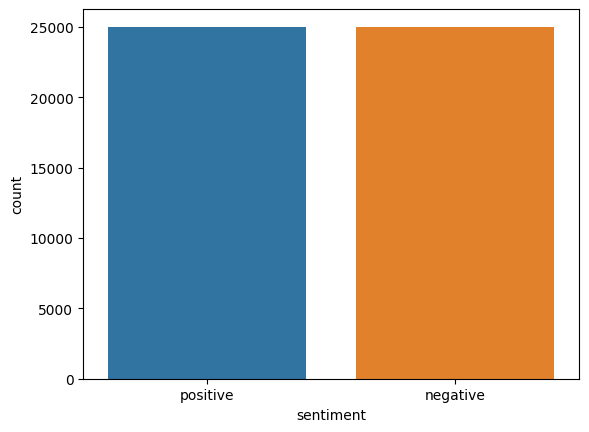

In [5]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [6]:
def preprocess_text(sen):
    sentence = remove_tags(sen)

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
X = []
sentences = list(movie_reviews['review'])

for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:
movie_reviews['review'][3],X[3]

("Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",
 'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you 

In [10]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=='positive' else 0, y)))

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
sentence = []
sentence.append('hello hi what')
sent = tokenizer.texts_to_sequences(sentence)
print(sent)

[[4936, 4853, 43]]


In [15]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
from numpy import array, asarray, zeros

embeddings_dictionary = dict()
glove_file = open('./datasets/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [17]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2023-09-07 21:28:23.045814: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37018800 exceeds 10% of free system memory.
2023-09-07 21:28:23.060314: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37018800 exceeds 10% of free system memory.
2023-09-07 21:28:23.074234: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37018800 exceeds 10% of free system memory.
2023-09-07 21:28:23.129335: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37018800 exceeds 10% of free system memory.


In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 5)                 50005     
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 9304711 (35.49 MB)
Trainable params: 50011 (195.36 KB)
Non-trainable params: 9254700 (35.30 MB)
_________________________________________________________________
None


In [20]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 5ms/step - loss: 0.6954 - acc: 0.4962 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/6
250/250 [==============================] - 1s 6ms/step - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6932 - val_acc: 0.5000


In [21]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.6932 - acc: 0.4961


In [22]:
print("Test Score", score[0])
print("Test Accuracy", score[1])

Test Score 0.6931901574134827
Test Accuracy 0.4961000084877014


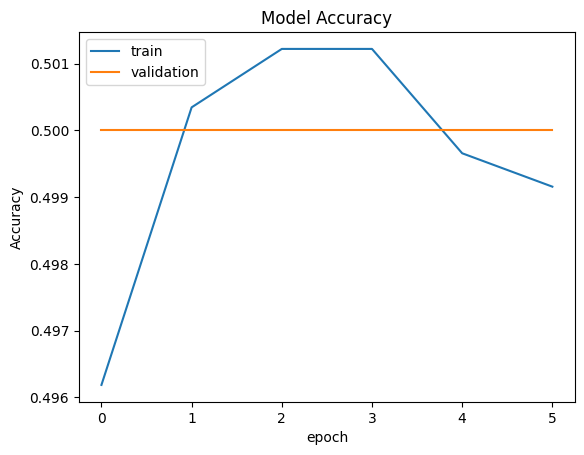

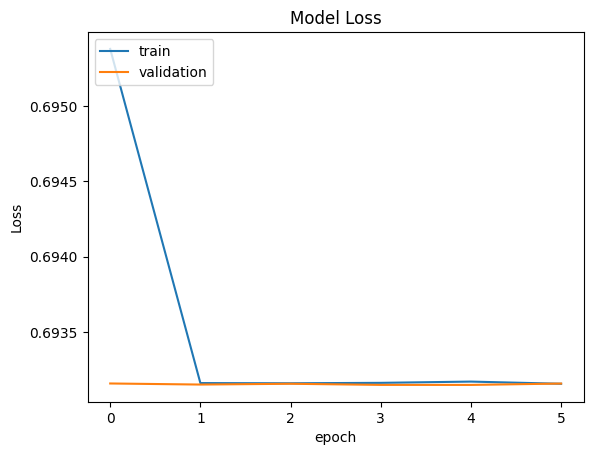

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
p = input('Enter your sentence')
p = preprocess_text(p)
print(p)

sentence = []
sentence.append(p)
sent = tokenizer.texts_to_sequences(sentence)
print(sent)

sent = pad_sequences(sent, padding='post', maxlen=maxlen)
print(sent)

(model.predict(sent) > 0.5).astype("int32")

Enter your sentenceThis is a very good movie
This is very good movie
[[8, 5, 48, 45, 12]]
[[ 8  5 48 45 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
1/1 [==============================] - 0s 64ms/step


array([[0]], dtype=int32)